In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import numpy as np

# Charger CIFAR-10 dataset à partir des fichiers .npy
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')

# Convertir en tensors et transférer en GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = torch.tensor(train_data).float().to(device)
train_labels = torch.tensor(train_labels).long().to(device)
test_data = torch.tensor(test_data).float().to(device)
test_labels = torch.tensor(test_labels).long().to(device)

# Définir un CNN de base
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Aplatir
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialiser le modèle, la perte, l'optimiseur et le scheduler
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
num_epochs = 10
batch_size = 64

# Fonction d'entraînement
def train_model(model, optimizer, criterion, scheduler):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Mélange aléatoire des données pour chaque époque
        indices = torch.randperm(train_data.size(0))
        shuffled_data = train_data[indices]
        shuffled_labels = train_labels[indices]

        for i in tqdm(range(0, len(shuffled_data), batch_size), desc=f"Époque {epoch + 1}/{num_epochs}"):
            inputs = shuffled_data[i:i + batch_size]
            labels = shuffled_labels[i:i + batch_size]

            # Forward + backward + optimiseur
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Scheduler step
            scheduler.step(epoch + i / len(shuffled_data))

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(shuffled_data):.4f}")
    
    print('Finished Training')

# Fonction de test
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = model(test_data)
        _, predicted = torch.max(outputs, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Entraîner et tester le modèle
train_model(model, optimizer, criterion, scheduler)
test_model(model)


Époque 1/10: 100%|██████████| 782/782 [00:04<00:00, 168.84it/s]


Epoch 1, Loss: 0.0212


Époque 2/10: 100%|██████████| 782/782 [00:04<00:00, 177.86it/s]


Epoch 2, Loss: 0.0144


Époque 3/10: 100%|██████████| 782/782 [00:04<00:00, 177.62it/s]


Epoch 3, Loss: 0.0110


Époque 4/10: 100%|██████████| 782/782 [00:04<00:00, 178.78it/s]


Epoch 4, Loss: 0.0086


Époque 5/10: 100%|██████████| 782/782 [00:04<00:00, 177.94it/s]


Epoch 5, Loss: 0.0073


Époque 6/10: 100%|██████████| 782/782 [00:04<00:00, 176.56it/s]


Epoch 6, Loss: 0.0097


Époque 7/10: 100%|██████████| 782/782 [00:04<00:00, 175.77it/s]


Epoch 7, Loss: 0.0074


Époque 8/10: 100%|██████████| 782/782 [00:04<00:00, 177.40it/s]


Epoch 8, Loss: 0.0049


Époque 9/10: 100%|██████████| 782/782 [00:04<00:00, 176.45it/s]


Epoch 9, Loss: 0.0029


Époque 10/10: 100%|██████████| 782/782 [00:04<00:00, 177.00it/s]


Epoch 10, Loss: 0.0019
Finished Training
Accuracy: 77.48%


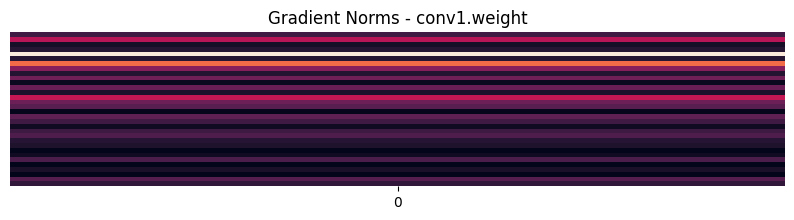

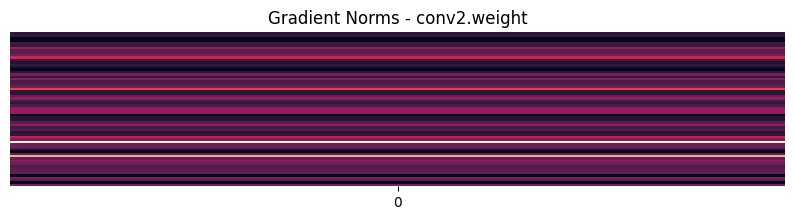

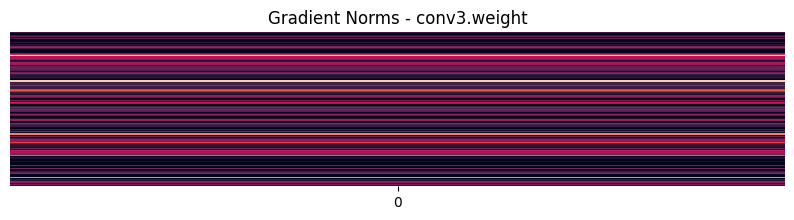

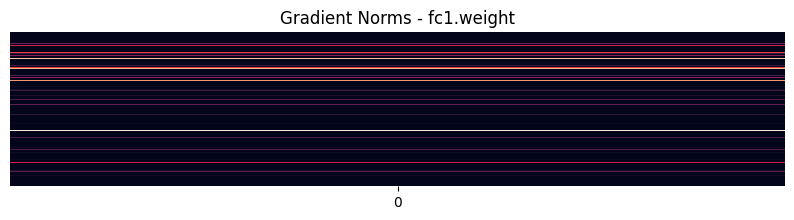

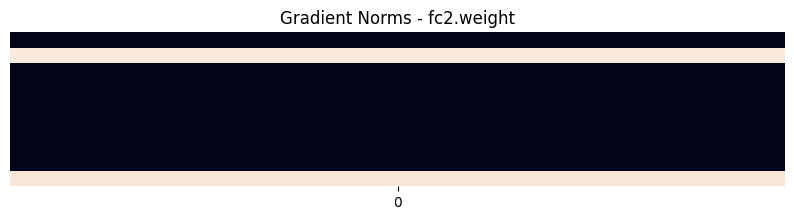

In [62]:
import torch
import random

# Sélectionner une image aléatoire dans les données de test
idx = random.randint(0, test_data.size(0) - 1)
random_image = test_data[idx:idx + 1]  # Ajouter un batch dimension avec [idx:idx + 1]
random_label = test_labels[idx:idx + 1]

# Assurez-vous que le mode d'entraînement est désactivé (pas besoin de dropout/batchnorm)
model.eval()

# Activer la traçabilité des gradients pour la passe arrière
random_image.requires_grad_(True)

# Forward pass : calculer la sortie du modèle
output = model(random_image)

# Prendre la classe prédite
_, predicted_class = torch.max(output, 1)

# Calculer la perte par rapport à la classe prédite
loss = criterion(output, random_label)

# Backward pass : calculer les gradients
model.zero_grad()
loss.backward()

# Récupérer les gradients pour chaque couche
gradients = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        gradients[name] = param.grad.clone()

# Afficher les gradients couche par couche
#for layer, grad in gradients.items():
    #print(f"Layer: {layer}, Gradient shape: {grad.shape}")

import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour calculer et visualiser la norme des gradients pour chaque couche
def visualize_gradient_norms(gradients):
    gradient_norms = {}
    
    for layer, grad in gradients.items():
        # Si le gradient est une couche convolutionnelle (4D)
        if len(grad.shape) == 4:  # Format [Batch, Channels, Height, Width]
            # Calculer la norme sur tous les canaux, largeurs, et hauteurs
            grad_norm = grad.norm(2, dim=[1, 2, 3]).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

        # Si le gradient est une couche fully connected (2D)
        elif len(grad.shape) == 2:  # Format [Output Neurons, Input Features]
            # Calculer la norme sur les poids
            grad_norm = grad.norm(2, dim=1).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

    # Visualiser les normes des gradients pour chaque couche
    for layer, norms in gradient_norms.items():
        plt.figure(figsize=(10, 2))
        sns.heatmap(norms.reshape(-1, 1), cbar=False, yticklabels=False)
        plt.title(f'Gradient Norms - {layer}')
        plt.show()

# Appel de la fonction après avoir récupéré les gradients
visualize_gradient_norms(gradients)


In [63]:

import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour calculer la norme des gradients pour chaque couche
def compute_gradient_norms(gradients):
    gradient_norms = {}
    
    for layer, grad in gradients.items():
        # Si le gradient est une couche convolutionnelle (4D)
        if len(grad.shape) == 4:  # Format [Batch, Channels, Height, Width]
            # Calculer la norme sur tous les canaux, largeurs, et hauteurs
            grad_norm = grad.norm(2, dim=[1, 2, 3]).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

        # Si le gradient est une couche fully connected (2D)
        elif len(grad.shape) == 2:  # Format [Output Neurons, Input Features]
            # Calculer la norme sur les poids
            grad_norm = grad.norm(2, dim=1).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

    return gradient_norms

# Fonction pour afficher les subplots côte à côte
def plot_gradients_and_image(image, gradients, true_class, selected_layers):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))

    # 1. Afficher l'image initiale (prendre la moitié de la taille du plot)
    img = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()  # Convertir de format torch à numpy
    img = (img * 0.5) + 0.5  # Dé-normaliser si nécessaire
    axes[0].imshow(img)
    axes[0].set_title("Image Initiale")
    axes[0].axis('off')  # Enlever les axes pour l'image

    # 2. Afficher les lignes de gradients pour les couches sélectionnées
    gradient_norms = compute_gradient_norms(gradients)

    for idx, layer in enumerate(selected_layers):
        if layer in gradient_norms:
            norms = gradient_norms[layer]
            sns.heatmap(norms.reshape(-1, 1), cbar=False, yticklabels=False, ax=axes[idx+1])
            axes[idx+1].set_title(f"Gradient {layer}")
        else:
            axes[idx+1].set_visible(False)  # Si la couche n'est pas présente

    # 6. Afficher le vecteur de classe attendue sous forme de vecteur vertical
    class_vector = torch.zeros(10)
    class_vector[true_class] = 1  # Mettre 1 à la position de la classe attendue
    sns.heatmap(class_vector.view(-1, 1).cpu().numpy(), cbar=False, ax=axes[-1])
    axes[-1].set_title("Classe Attendue")
    axes[-1].axis('off')  # Pas de cadre pour la classe

    plt.tight_layout()
    plt.show()



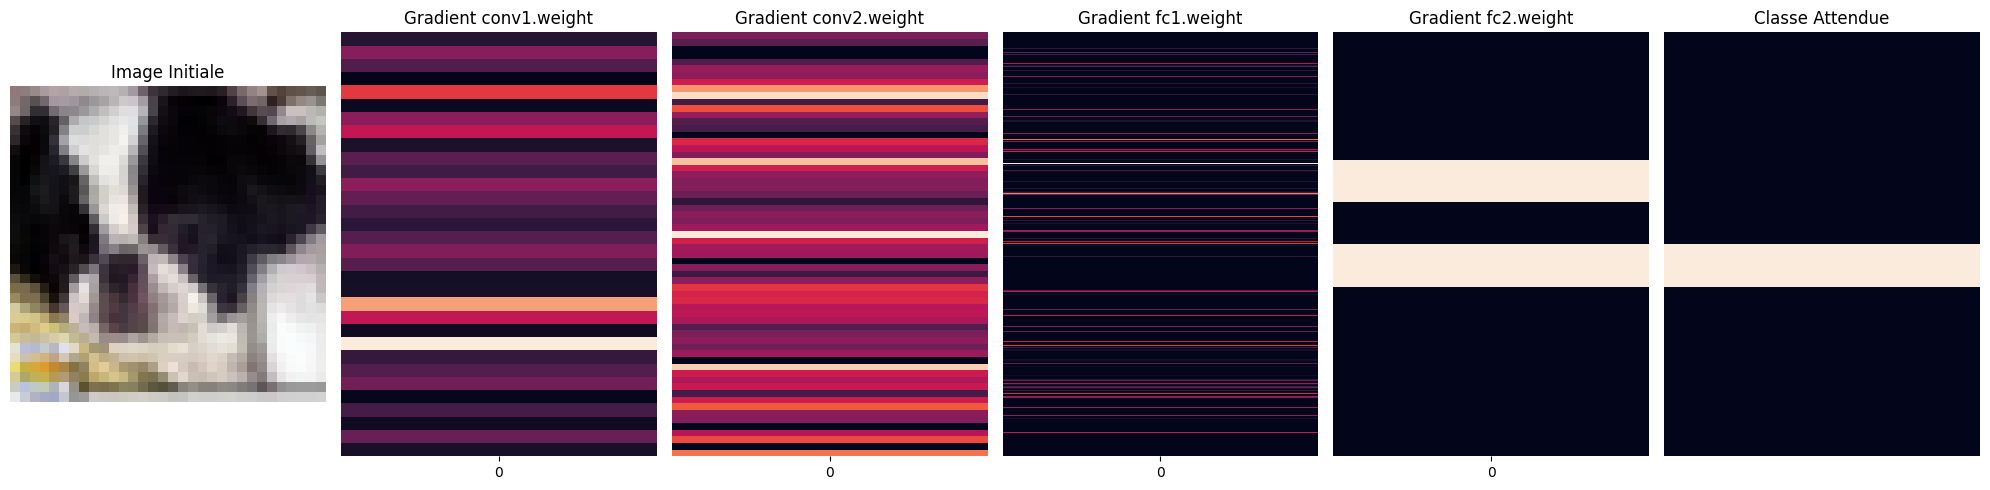

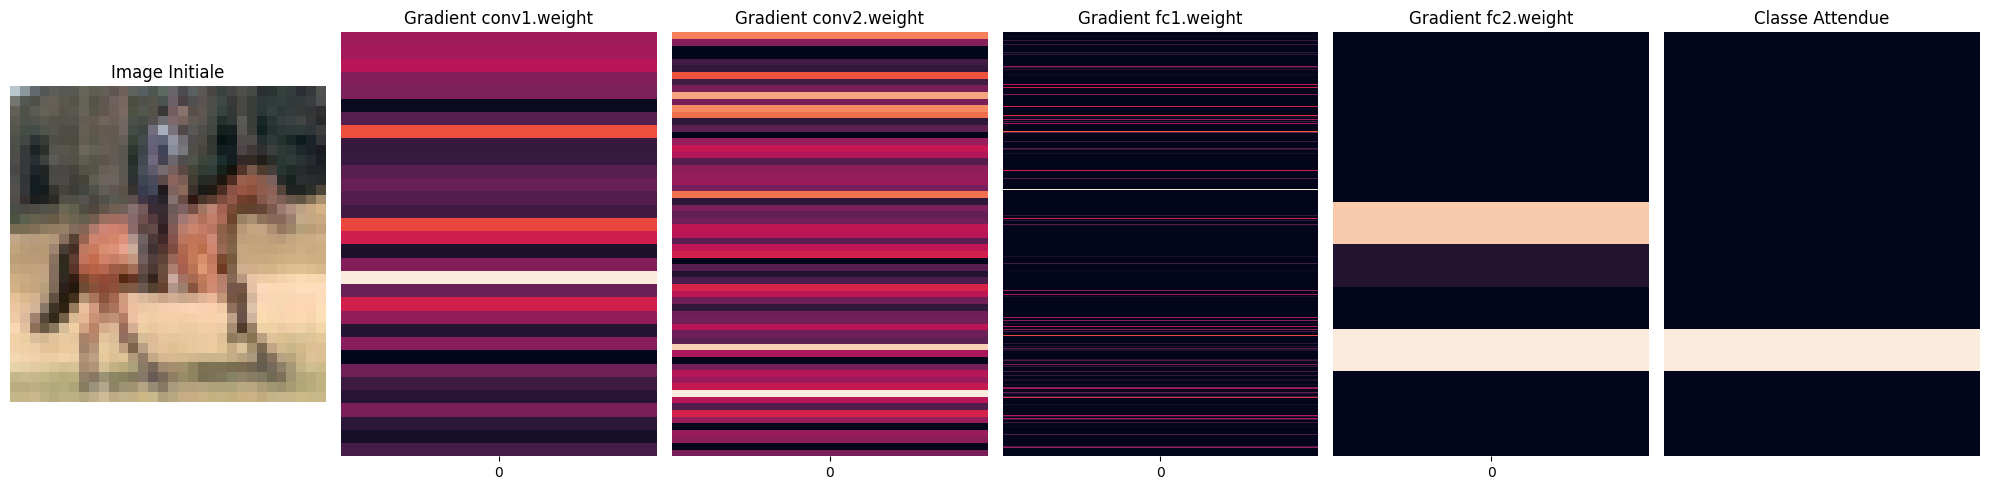

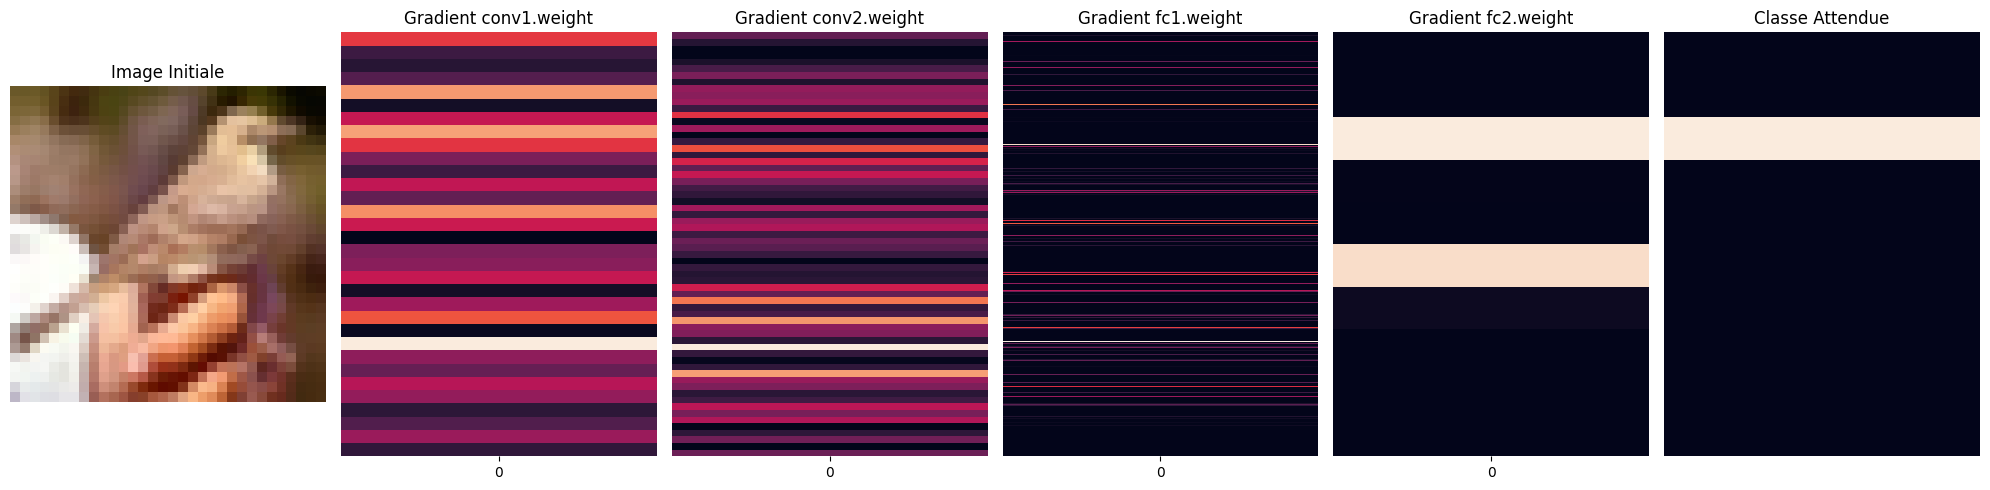

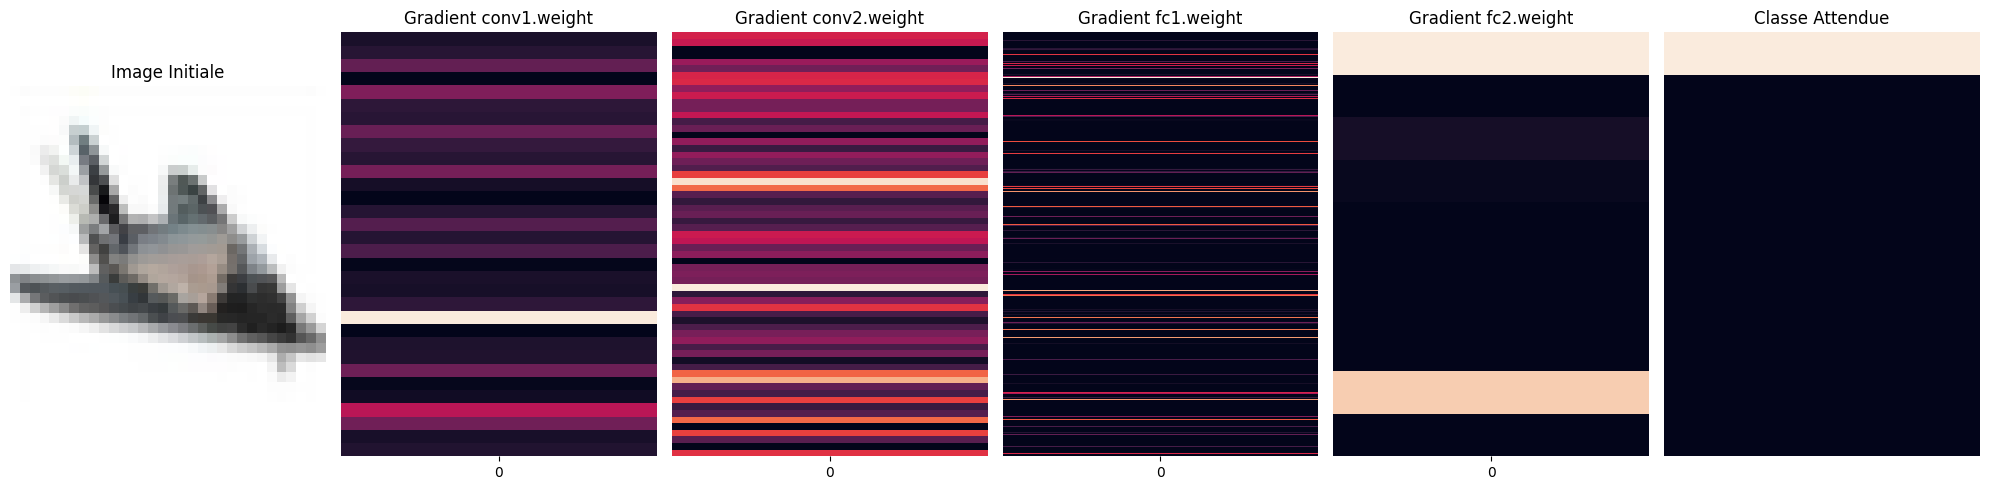

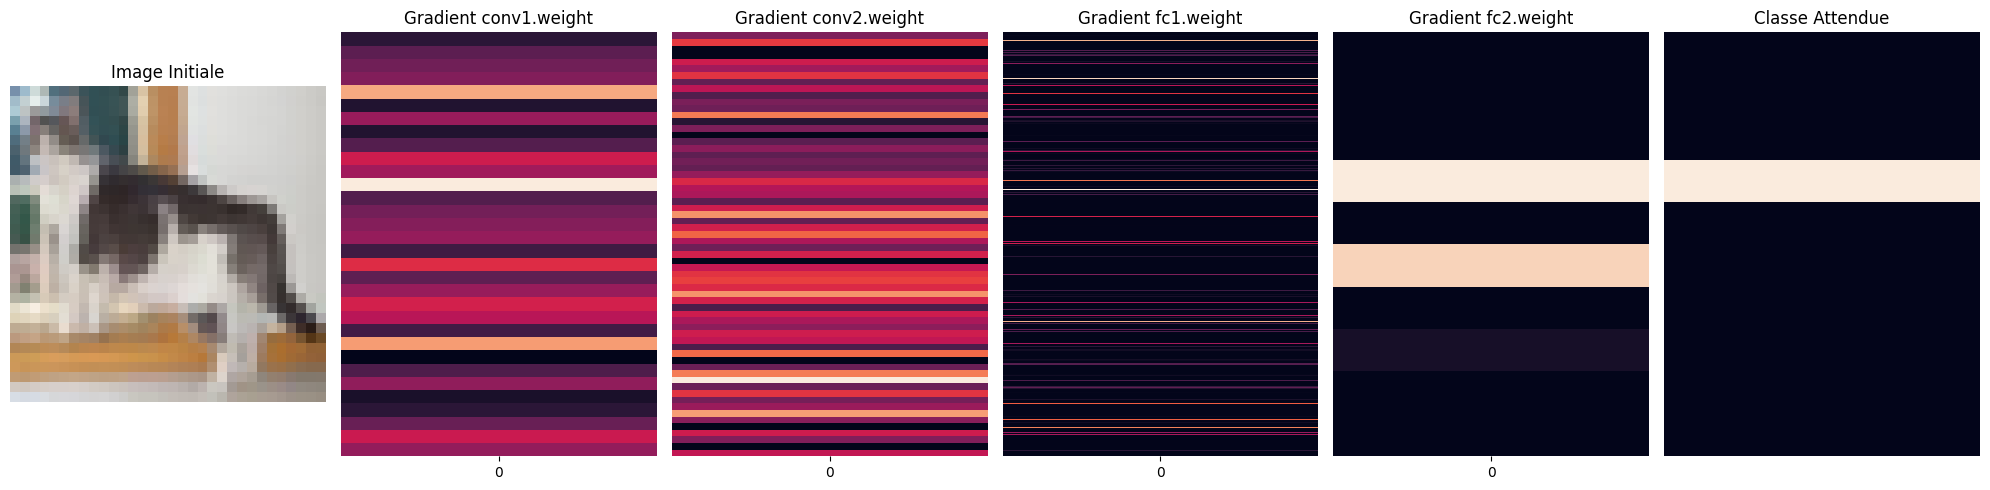

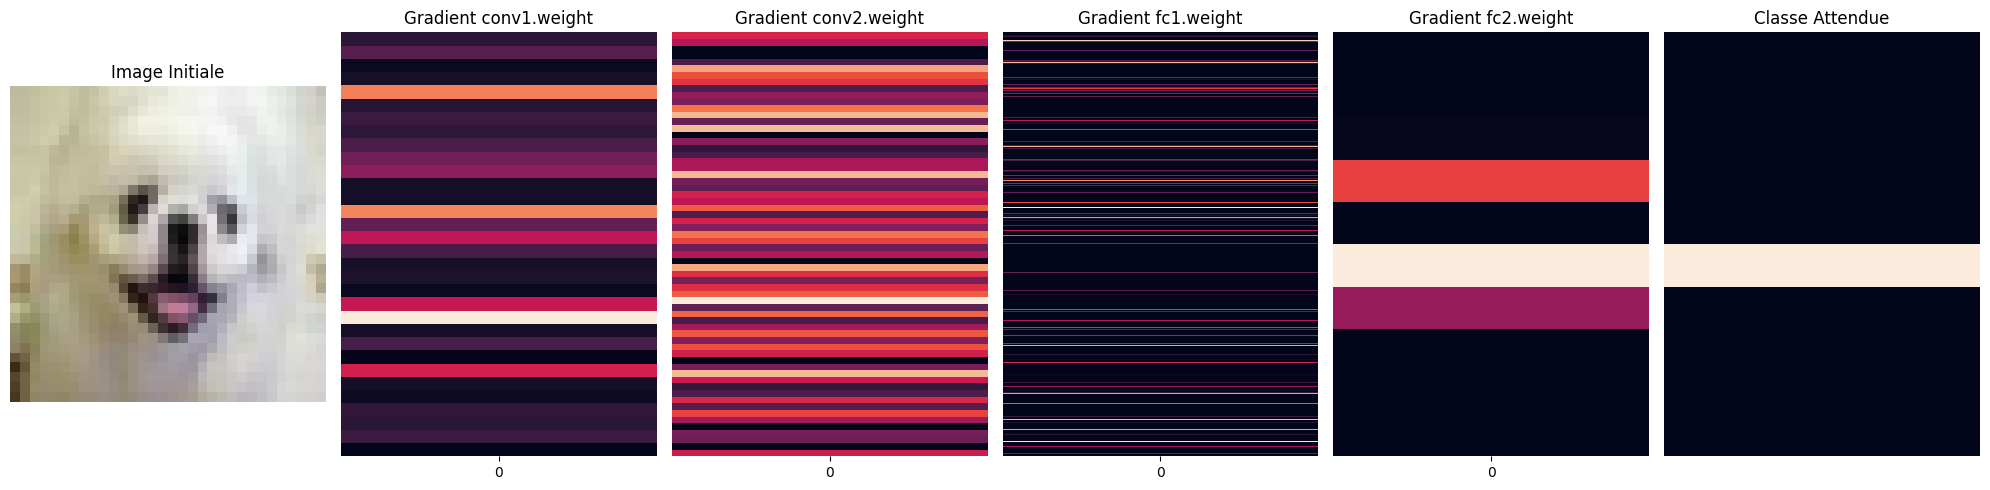

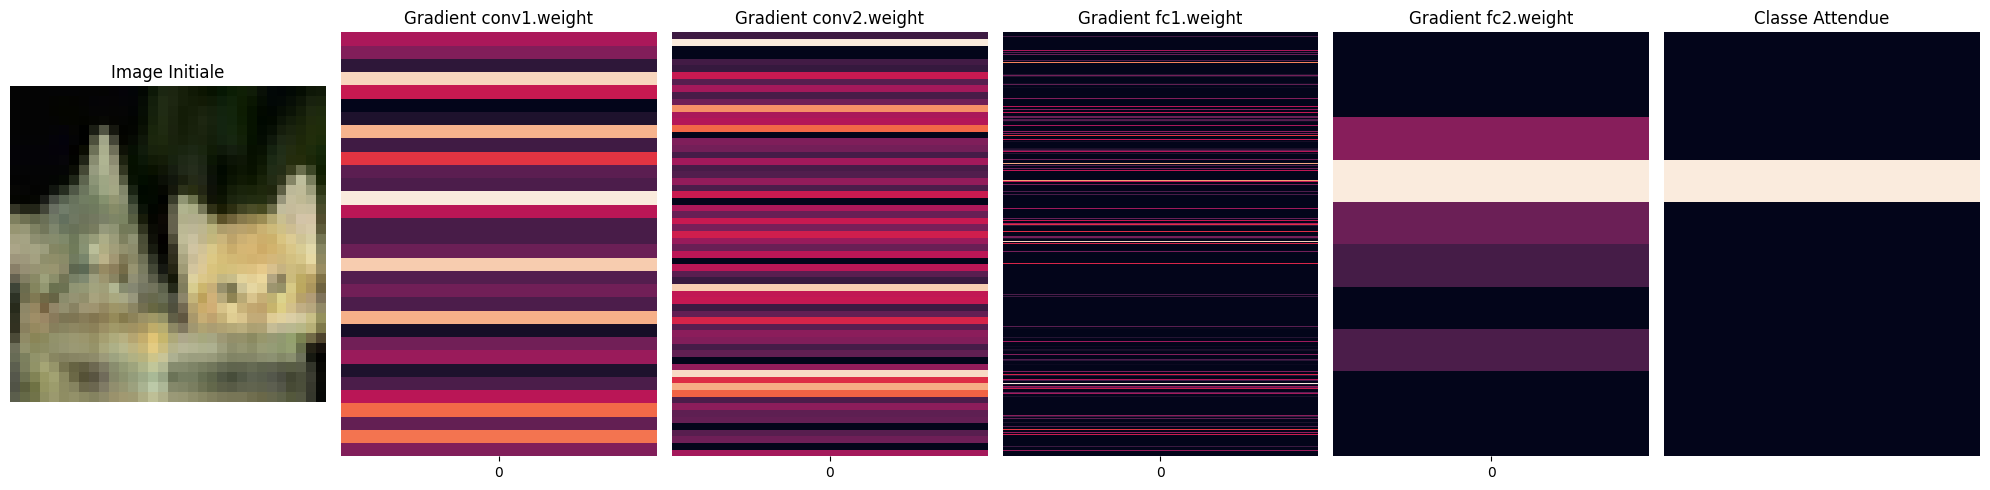

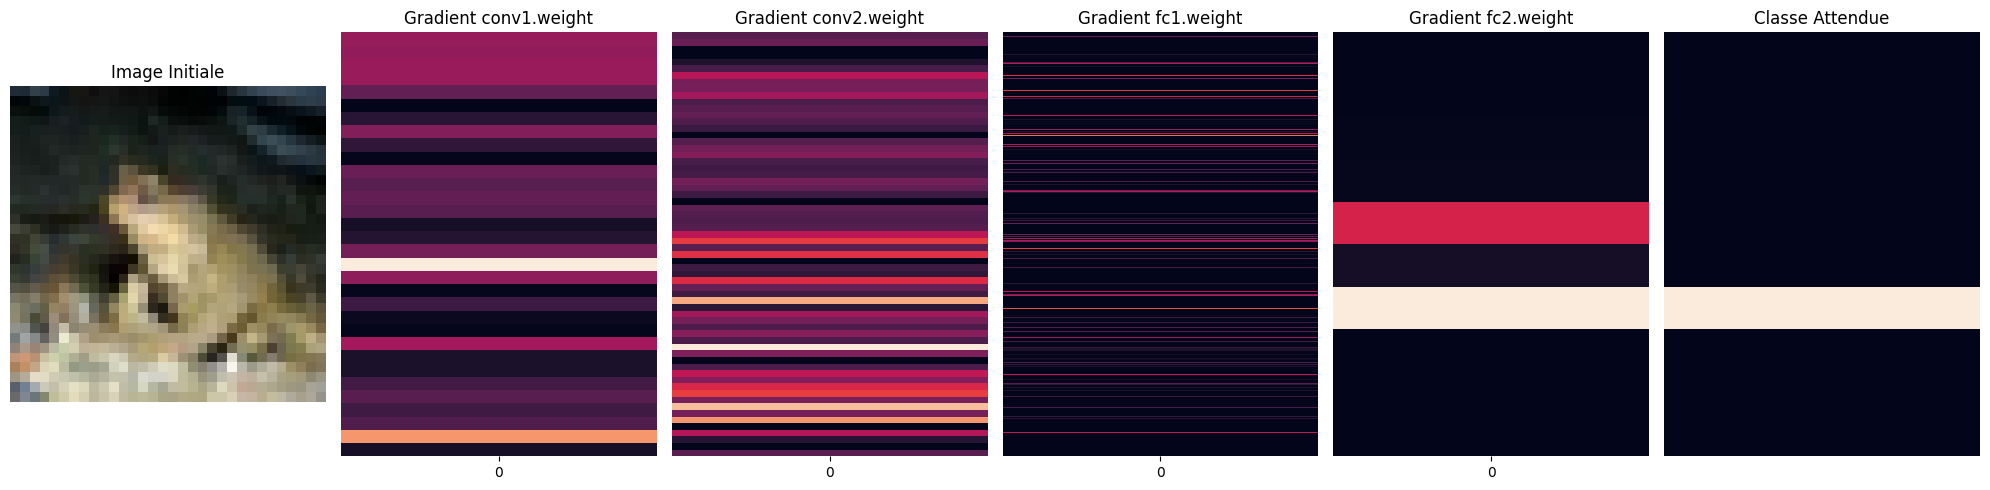

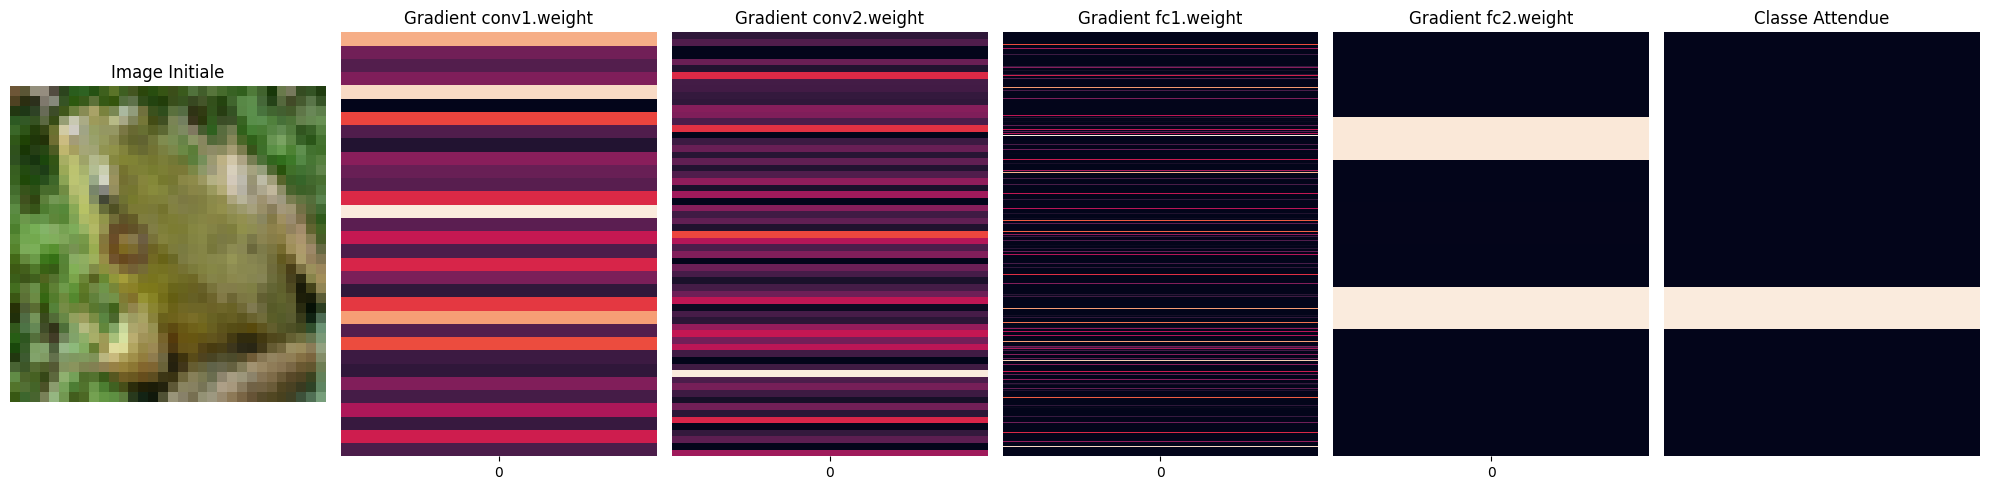

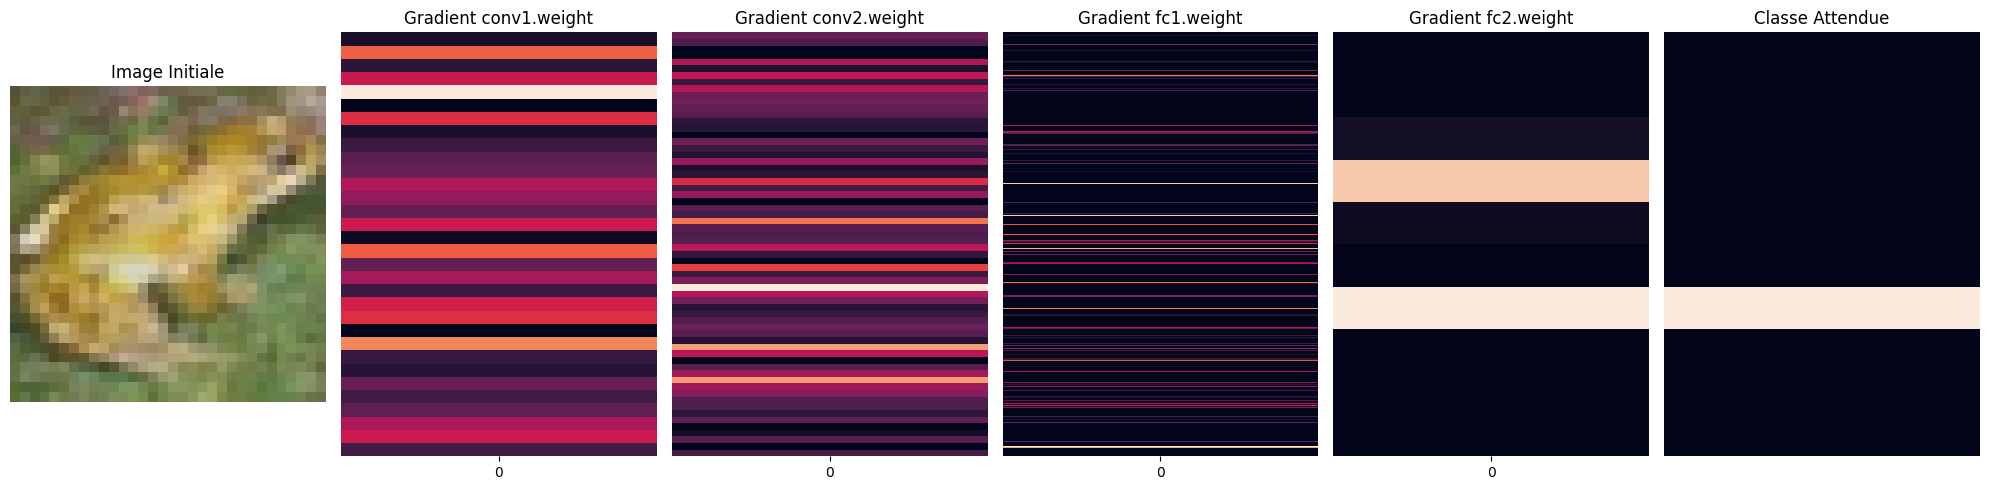

In [64]:

for i in range (10):
    # Image aléatoire pour le test
    idx = random.randint(0, test_data.size(0) - 1)
    random_image = test_data[idx:idx + 1]
    random_label = test_labels[idx:idx + 1]

    # Appel à ton modèle pour calculer les gradients
    random_image.requires_grad_(True)
    output = model(random_image)
    loss = criterion(output, random_label)
    model.zero_grad()
    loss.backward()

    # Récupérer les gradients pour chaque couche
    gradients = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients[name] = param.grad.clone()

    # Spécifier les couches à afficher dans l'ordre voulu (indices 1, 2, 3, 5)
    selected_layers = [
        "conv1.weight",  # Première couche convolutionnelle
        "conv2.weight",  # Deuxième couche convolutionnelle
        "fc1.weight",    # Troisième couche (fully connected)
        "fc2.weight"     # Cinquième couche (fully connected)
    ]

    # Appel de la fonction pour afficher les subplots
    plot_gradients_and_image(random_image, gradients, random_label, selected_layers)


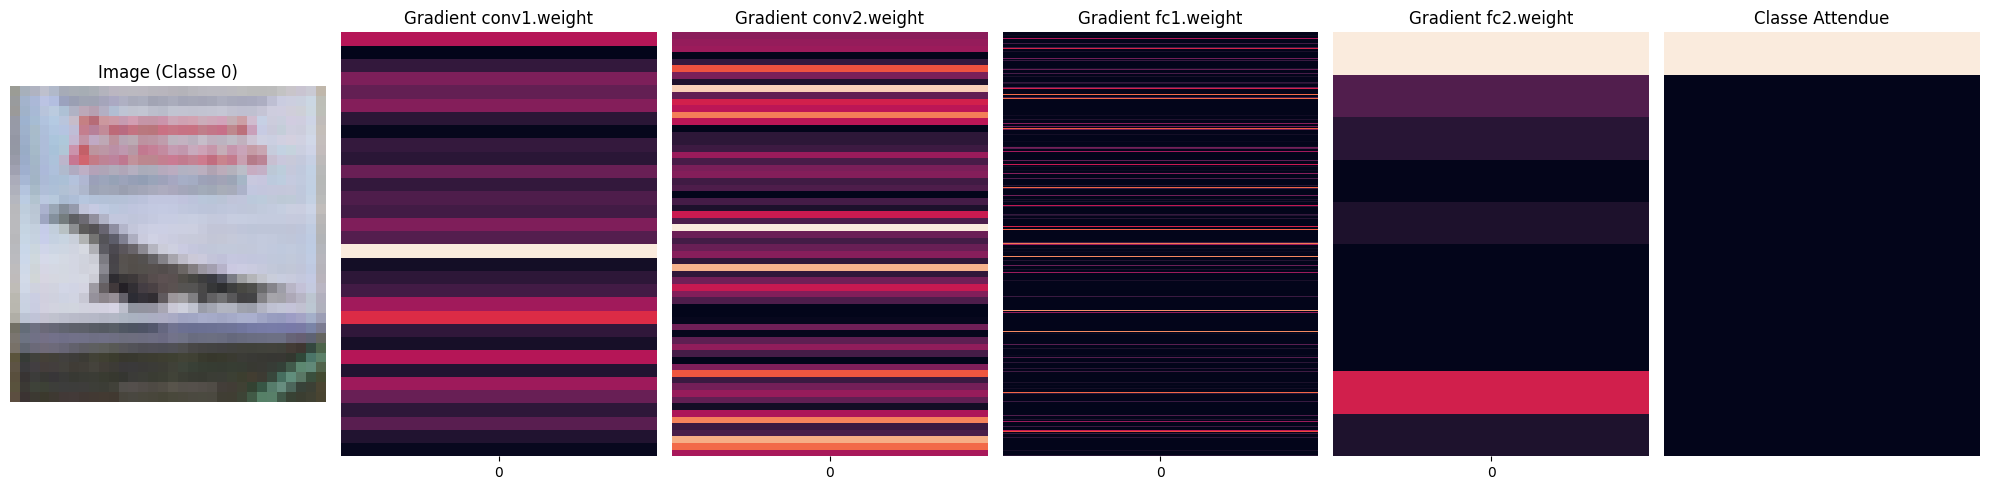

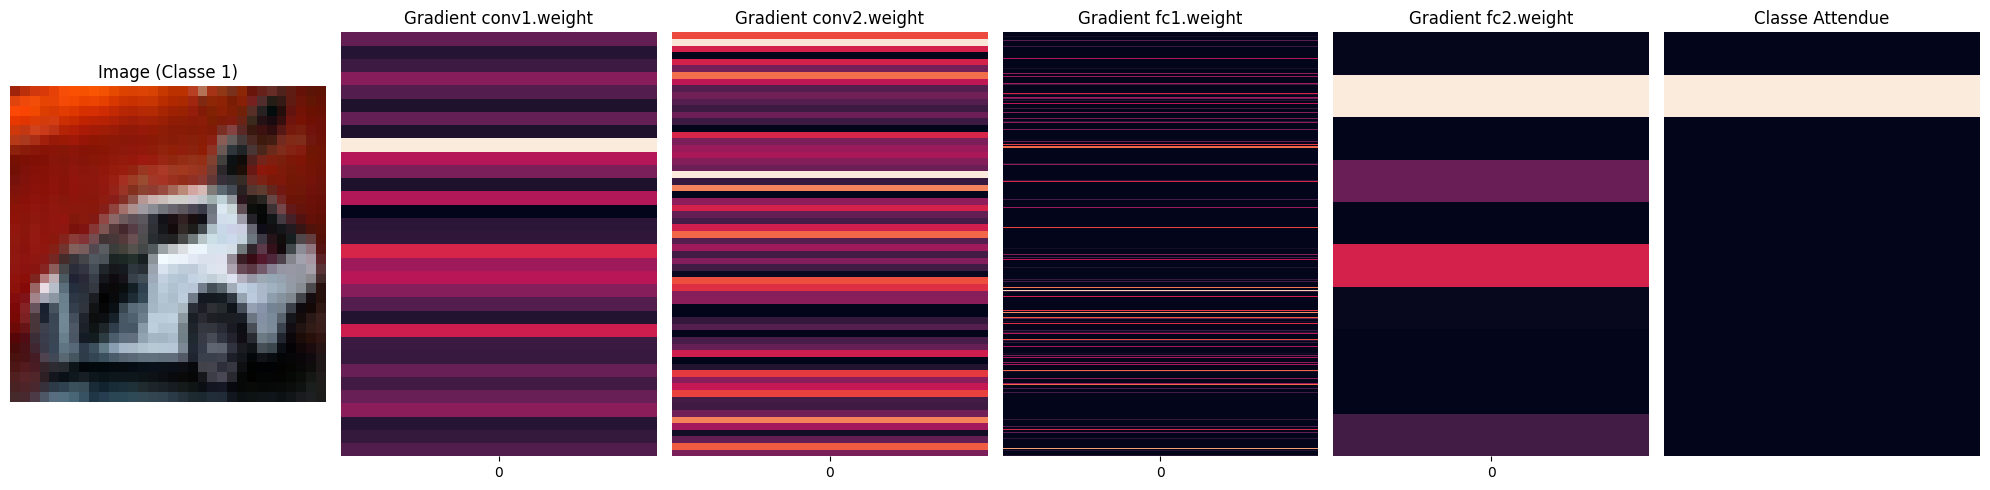

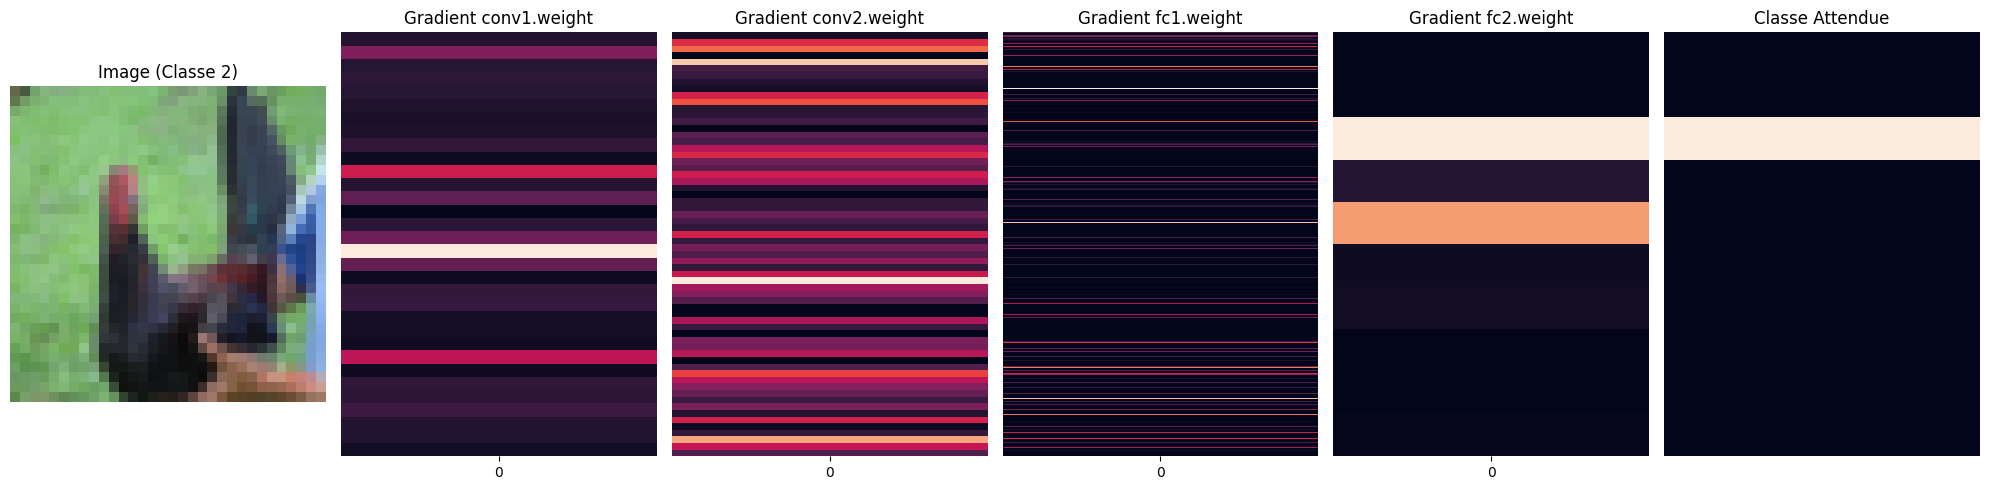

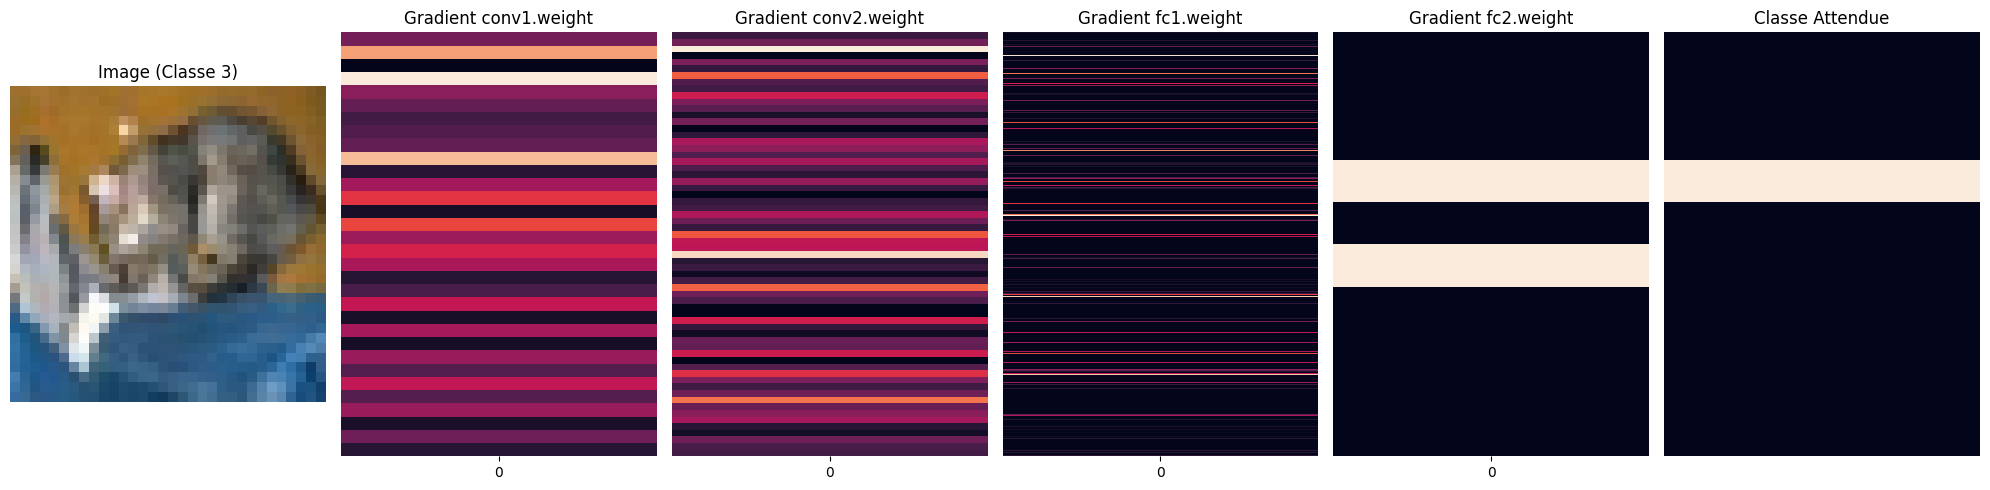

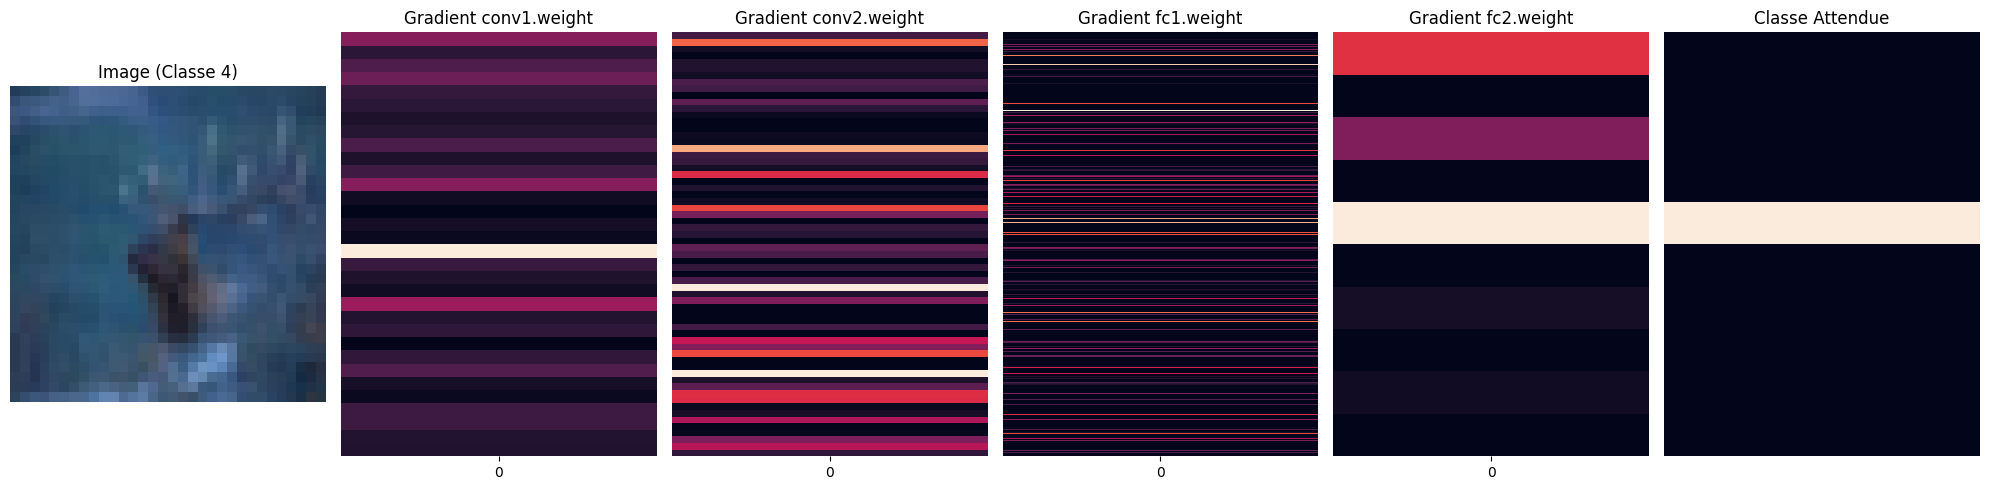

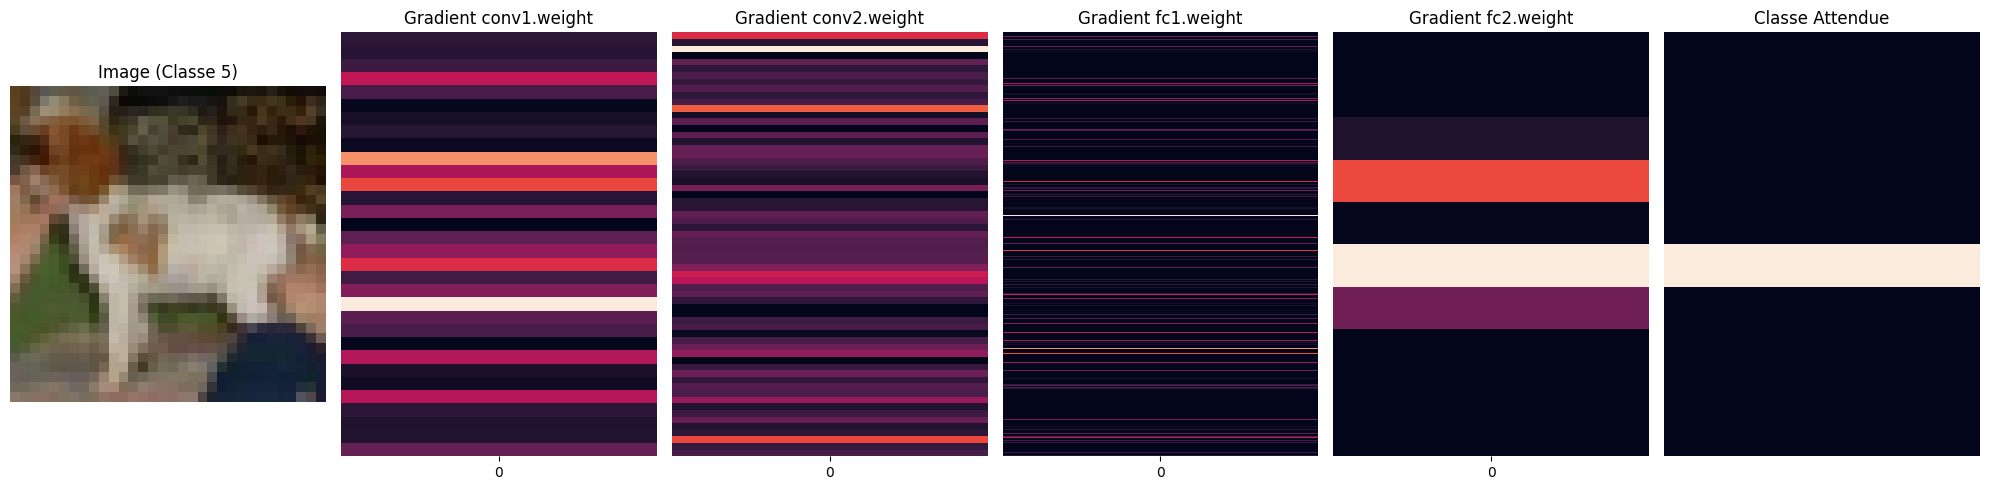

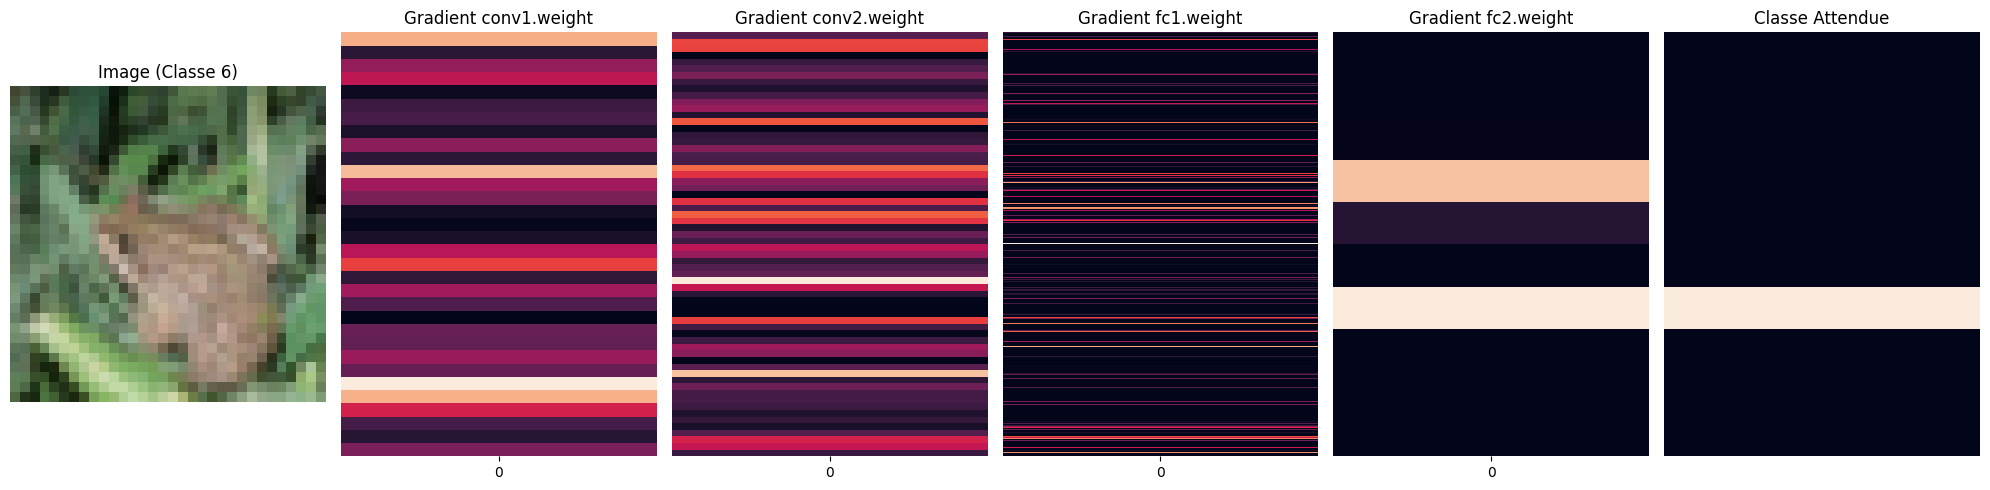

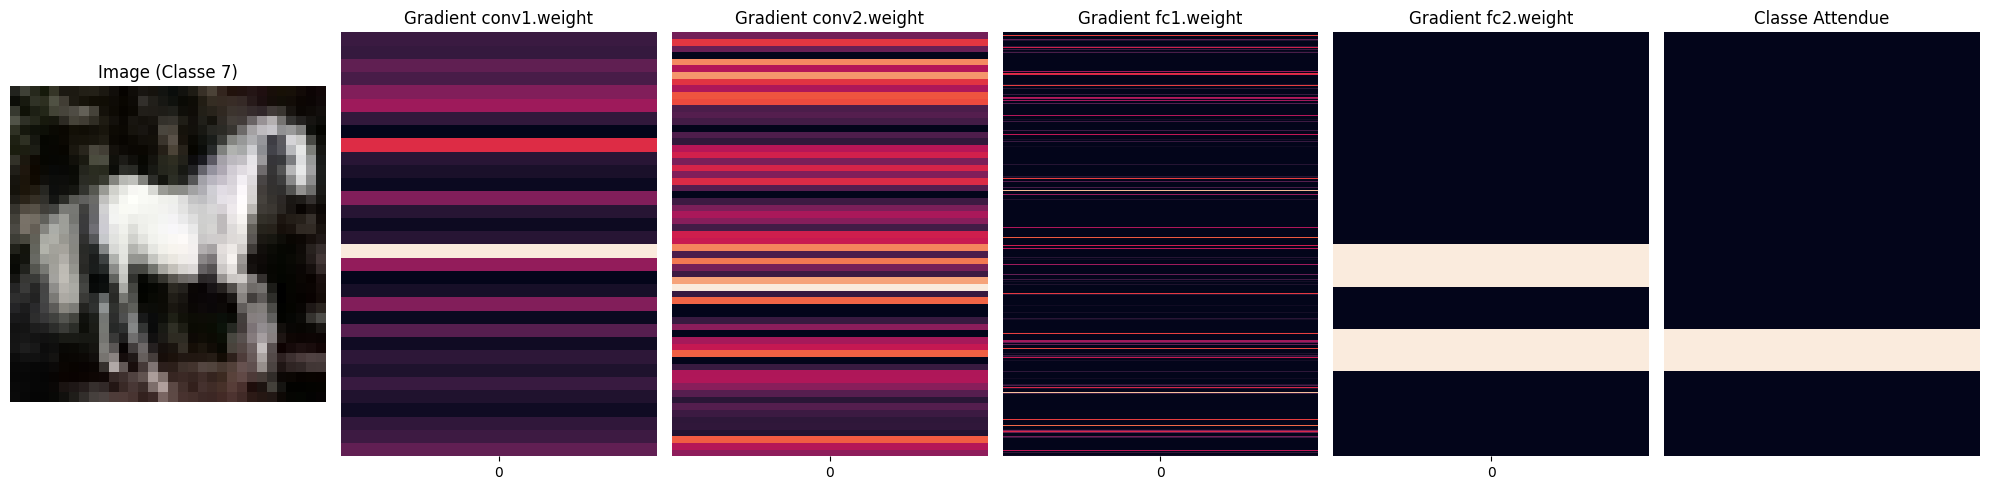

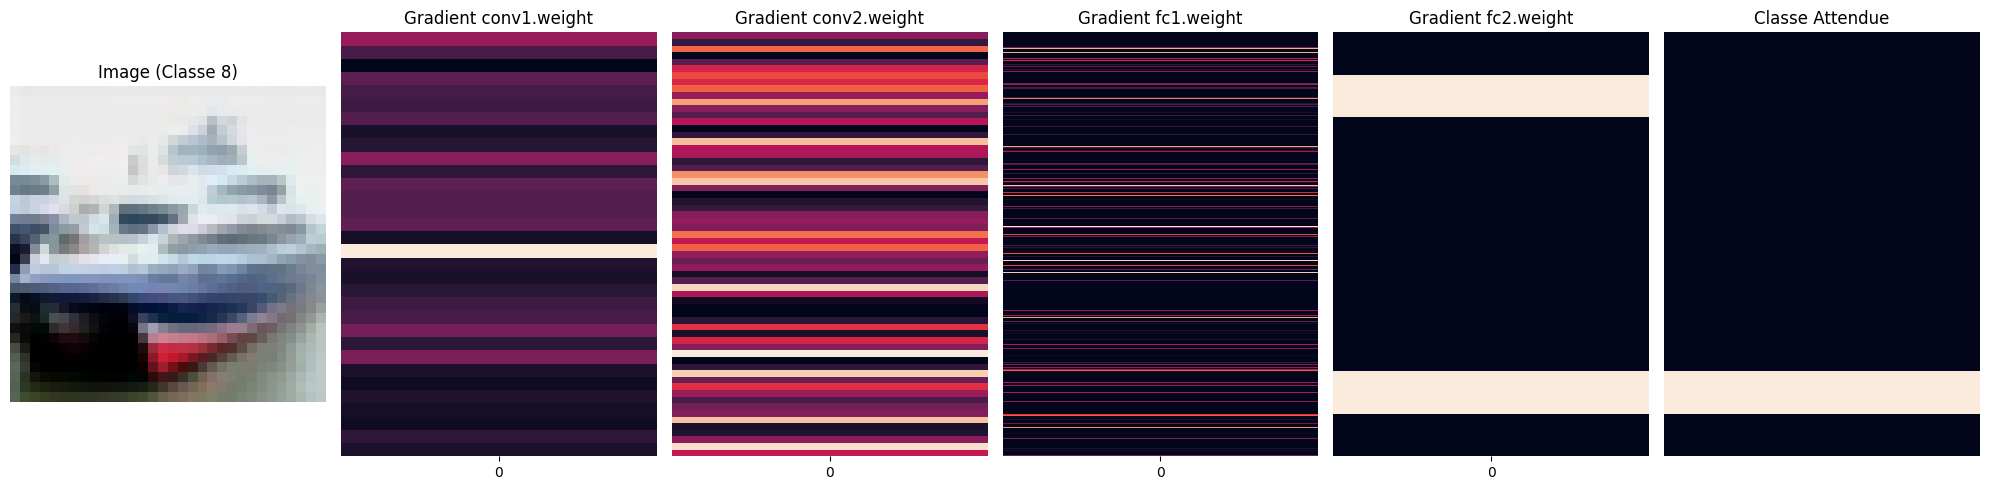

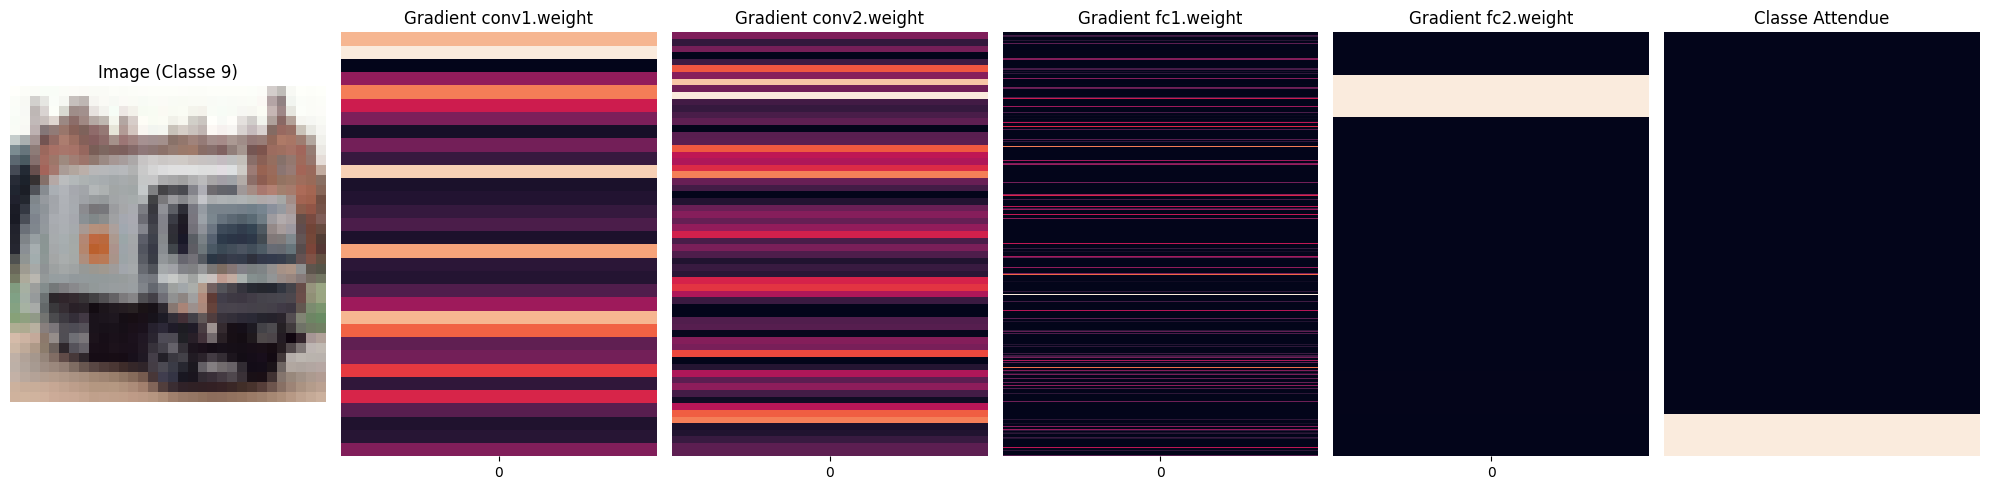

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Fonction pour calculer la norme des gradients pour chaque couche
def compute_gradient_norms(gradients):
    gradient_norms = {}
    
    for layer, grad in gradients.items():
        # Si le gradient est une couche convolutionnelle (4D)
        if len(grad.shape) == 4:  # Format [Batch, Channels, Height, Width]
            grad_norm = grad.norm(2, dim=[1, 2, 3]).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

        # Si le gradient est une couche fully connected (2D)
        elif len(grad.shape) == 2:  # Format [Output Neurons, Input Features]
            grad_norm = grad.norm(2, dim=1).cpu().detach().numpy()
            gradient_norms[layer] = grad_norm

    return gradient_norms

# Fonction pour afficher les subplots côte à côte
def plot_gradients_and_image(image, gradients, true_class, selected_layers, class_name):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))

    # 1. Afficher l'image initiale
    img = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()  # Convertir de format torch à numpy
    img = (img * 0.5) + 0.5  # Dé-normaliser si nécessaire
    axes[0].imshow(img)
    axes[0].set_title(f"Image ({class_name})")
    axes[0].axis('off')  # Enlever les axes pour l'image

    # 2. Afficher les lignes de gradients pour les couches sélectionnées
    gradient_norms = compute_gradient_norms(gradients)

    for idx, layer in enumerate(selected_layers):
        if layer in gradient_norms:
            norms = gradient_norms[layer]
            sns.heatmap(norms.reshape(-1, 1), cbar=False, yticklabels=False, ax=axes[idx+1])
            axes[idx+1].set_title(f"Gradient {layer}")
        else:
            axes[idx+1].set_visible(False)  # Si la couche n'est pas présente

    # 6. Afficher le vecteur de classe attendue sous forme de vecteur vertical
    class_vector = torch.zeros(10)
    class_vector[true_class] = 1  # Mettre 1 à la position de la classe attendue
    sns.heatmap(class_vector.view(-1, 1).cpu().numpy(), cbar=False, ax=axes[-1])
    axes[-1].set_title("Classe Attendue")
    axes[-1].axis('off')  # Pas de cadre pour la classe

    plt.tight_layout()
    plt.show()

# Boucle sur les classes de CIFAR-10
for class_idx in range(10):
    # Filtrer les images et labels correspondant à la classe actuelle
    class_images = test_data[test_labels == class_idx]
    class_labels = test_labels[test_labels == class_idx]

    # Prendre la première image de la classe
    if class_images.size(0) > 0:
        first_image = class_images[0:1]  # Prendre la première image
        true_label = class_labels[0:1]   # Prendre le label correspondant

        # Initialiser les gradients à 0
        gradient_sums = {name: 0 for name, param in model.named_parameters() if param.requires_grad}

        # Calculer les gradients pour la première image
        first_image.requires_grad_(True)
        output = model(first_image)
        loss = criterion(output, true_label)
        model.zero_grad()
        loss.backward()

        # Ajouter les gradients pour chaque couche
        for name, param in model.named_parameters():
            if param.grad is not None:
                gradient_sums[name] += param.grad.clone()

        # Moyenne des gradients (ici ce sera juste le gradient de la première image)
        gradients_avg = {name: grad for name, grad in gradient_sums.items()}

        # Spécifier les couches à afficher dans l'ordre voulu
        selected_layers = [
            "conv1.weight",  # Première couche convolutionnelle
            "conv2.weight",  # Deuxième couche convolutionnelle
            "fc1.weight",    # Troisième couche (fully connected)
            "fc2.weight"     # Cinquième couche (fully connected)
        ]

        # Afficher le plot pour la classe actuelle
        plot_gradients_and_image(first_image, gradients_avg, torch.tensor(class_idx), selected_layers, f"Classe {class_idx}")
